In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import xesmf as xe
#from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils

import geopandas

from numba import jit
import numpy as np
from numba import guvectorize, float64, int64, void

import scipy.signal as signal


# Create the parser
parser = argparse.ArgumentParser()
# Add an argument
parser.add_argument('--start_year', type=int, required=True)
parser.add_argument('--end_year', type=int, required=True)

# Parse the argument
args = parser.parse_args()
# check it worked
print('Start year', args.start_year, 'End year', args.end_year, )


In [2]:
#import data from:
### Gallagher, Kevin P. (2021), “China’s Global Energy Finance,” Global Development Policy Center, Boston University.
### Gallagher, Kevin P., Li, Zhongshu, Chen, Xu, Ma, Xinyue (2019), “China’s Global Power Database,” Global Development Policy Center, Boston University.

In [3]:
years = 50
coal_year_range = np.arange(5,35)#np.arange(args.start_year, args.end_year)

In [4]:
## Add time dimension
length_simulation = years*365

time_array = np.arange(0, length_simulation)

In [5]:
CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')

In [6]:
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

In [7]:
CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})

In [8]:
percent = np.arange(0,10)

In [9]:
print('Emis data prepped and loaded')

Emis data prepped and loaded


# Create Scenario

In [10]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        year_early is the number of years the plant runs
        min_comission_yr is the earliest year a plant was built and is where our timeline starts
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant'''
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365
    E = np.zeros(len(time_array))
    #print(min_comission_yr)
    #print(shutdown_days)
    test_array = np.where(time_array <= year_early*365, True, False)
    #print('test array len', len(test_array))
    #plt.plot(test_array)
    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['BC_(g/day)'].sum()
    #fig, ax = plt.subplots()
    #plt.plot(E)
    #plt.title('E')
    #print(E)
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        #print(np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r))
        test_array = np.where((time_array <= (year_comis-min_comission_yr)*365 + shutdown_days), True, False)
        #plt.plot(test_array)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        E += test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum()
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)



# Convolve with G

In [11]:
ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/RRTMG_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);

In [12]:
#import the green's function and set our time step
G = xr.open_dataarray('Outputs/G_all_loc_all_times_BC_total.nc4', chunks = 'auto')
dt = 1 #day

In [13]:
G_lev0 = G.isel(lev = 0).mean(dim = 'run').compute()
G_lev0 = G_lev0.rename({'time':'s'})
print('G prepped')

G prepped


In [14]:
def np_to_xr(C, G, E):
    E_len = len(E)
    G_len = len(G.s)
    C = xr.DataArray(
    data = C,
    dims = ['s','lat','lon'],
    coords = dict(
        s = (['s'], np.arange(0, C.shape[0])), #np.arange(0,(E_len+G_len))),
        lat = (['lat'], G.lat.values),
        lon = (['lon'], G.lon.values)
            )
        )
    return(C)

signal.convolve(G_lev0.to_numpy(), 
                E_CO2_all_opts[5][0][:10][..., None, None], mode = 'full').dtype

## testing

In [15]:
G_np = G_lev0.to_numpy()

In [16]:
import numpy as np
from numba import njit
from numba.core import types
from numba.typed import Dict

Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64[:],
        )

In [17]:
C_out = Dict.empty(
    key_type=types.float64,
    value_type=types.float64[:],
)
E_CO2_all_opts = Dict.empty(
    key_type=types.float64,
    value_type=types.float64[:],
)

E_CO2_all_opts = {}
for year in coal_year_range:
    E_CO2_all_opts[year] = Dict.empty(
    key_type=types.float64,
    value_type=types.float64[:],
)
    for r in percent:
        E_CO2_all_opts[year][r] = early_retirement_by_CO2_year(year, CGP_df, np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r), time_array, 40)
print('Emis profiiles created')

In [19]:
year = 5

In [25]:
for pc in percent:
    E_CO2_all_opts[pc] = early_retirement_by_CO2_year(year, CGP_df, np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],pc), time_array, 40)
@jit
def convolve(C_out, year):
    for pc in percent:
        for 
        C_out[pc] = np.convolve(G_np, E_CO2_all_opts[pc][..., None, None], 
                                         mode = 'full')

In [26]:
convolve(C_out, 5)

/tmp/ipykernel_3447045/764685413.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "convolve" failed type inference due to: No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 1d, A), Tuple(..., none, none))
 
There are 22 candidate implementations:
      - Of which 20 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(array(float64, 1d, A), Tuple(..., none, none))':
       No match.
      - Of which 2 did not match due to:
      Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 166.
        With argument(s): '(array(float64, 1d, A), Tuple(..., none, none))':
       Rejected as the implementation raised a specific error:
         NumbaTypeError: unsupported array index type none in Tuple(..., none, none)
  raised from /home/emfreese/anaconda3/envs/gchp/lib/python

ValueError: object too deep for desired array

In [ ]:
for yr in coal_year_range:
    C_out[yr] = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:],
    )
    for pc in percent:    
        C_out[yr][pc] =  signal.convolve(G_lev0.to_numpy(), 
                                         E_CO2_all_opts[yr][pc][..., None, None], 
                                         mode = 'full')
        C_out[yr][pc] = np_to_xr(C_out[yr][pc], G_lev0, E_CO2_all_opts[yr][pc])
        #C_sum[yr][pc] = C_out[yr][pc].sum(dim = 's')
        break
    break
break

## testing

C_out = {}
C_sum = {}
for yr in coal_year_range:
    C_out[yr] = {}
    C_sum[yr] = {}
    for pc in percent:    
        C_out[yr][pc] =  signal.convolve(G_lev0.to_numpy(), E_CO2_all_opts[yr][pc][..., None, None], mode = 'full')
        C_out[yr][pc] = np_to_xr(C_out[yr][pc], G_lev0, E_CO2_all_opts[yr][pc])
        #C_sum[yr][pc] = C_out[yr][pc].sum(dim = 's')
        break
    break
break

In [ ]:
C_sum.to_csv('Outputs/C_sum.csv')

In [ ]:
C_out.to_netcdf('Outputs/C_out.nc')

In [4]:
ds = xr.open_dataset('Outputs/C_out_5_6_1_5.nc')

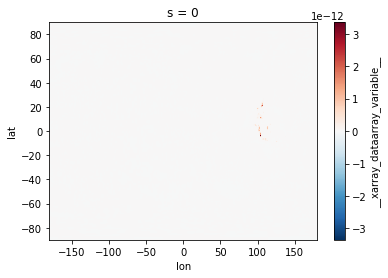

In [13]:
ds['__xarray_dataarray_variable__'].isel(s = 0).plot()